In [4]:
import objaverse
import objaverse.xl as xl
import pandas as pd
import pickle
import os
from collections import Counter
from random import sample
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.15)

# Understanding Objaverse
- `ObjaverseXL` has $\gt 10m$ objects (Thingiverse, GitHub, Polycam, etc.), with *unconsistent annotations*
- `Objaverse 1.0` has $~800k$ objects (mostly from Sketchfab), with *clean annotations*. It's been filtered to include only good models.

## ObjaverseXL annotations are lacking

In [ ]:
# 12s
# This downloads a single Parquet file (~100 MB) and caches it locally under ~/.objaverse
annotations_xl = (xl.get_annotations(refresh=False) 
                  if not os.path.exists('objaverse xl.pkl') 
                  else pickle.load(open('objaverse xl.pkl', 'rb')))

In [ ]:
annotations_xl.head()

,fileIdentifier,source,license,fileType,sha256,metadata
0,https://github.com/GameGC/Testovoe-SPB-Git/blo...,github,None,obj,fca3990d6d91e110cb920aa3da1a84e54b4a00cde7ad1e...,{}
1,https://github.com/9-zzz/RitualRex-GGJ2016/blo...,github,None,blend,09dc2689b8d0510885e19a7b525ee44709849d2601add8...,{}
2,https://github.com/mattoverby/mesh-data/blob/2...,github,MIT License,obj,f9d17190b54b548c6a3e6feebe7b2951a9b8060c507874...,{}
3,https://github.com/0010cha/data_origami/blob/0...,github,MIT License,ply,f25184898312af8ed5e77cfe675d2251c9893ac5ccc3a1...,{}
4,https://github.com/Xrvitd/Point2Skeleton_withC...,github,MIT License,ply,d721e6b1b97a83d1f6700045efcb478a1db4686b0571f6...,{}


Here we can see that the annotations are both sparse and scarce. Only few of the samples actually have a value in the metadata column.

## Objaverse 1.0 annotations are structured and consistent

In [7]:
# 60s-23s
annotations = (objaverse.load_annotations()
               if not os.path.exists('objaverse 1.0.pkl') 
               else pickle.load(open('objaverse 1.0.pkl', 'rb')))

In [5]:
def convert_annotations(annotations: dict[str, any]) -> pd.DataFrame:
    keys_to_keep = ['uri', 'uid', 'name', 'likeCount', 'animationCount', 'viewerUrl', 'commentCount', 'tags',
                    'categories', 'thumbnails', 'description', 'faceCount', 'createdAt', 'vertexCount', 'isAgeRestricted', 'archives']

    def clean_annotation(annotation: dict[str, any]) -> pd.DataFrame:
        # Remove unnecessary keys
        for key in list(annotation.keys()):
            if key not in keys_to_keep:
                annotation.pop(key)
        # Keep only "name" field in "tags" and "categories"
        annotation['tags'] = [tag['name'] if isinstance(
            tag, dict) else tag for tag in annotation['tags']]
        annotation['categories'] = [category['name'] if isinstance(category, dict) else category
                                    for category in annotation['categories']]
        # Keep only "url" field in "thumbnails"
        if isinstance(annotation['thumbnails'], dict):
            annotation['thumbnails'] = [thumbnail['url']
                                        for thumbnail in annotation['thumbnails']['images']]
        return annotation

    cleaned_annotations = list(tqdm(map(clean_annotation, annotations), total=len(
        annotations), desc="Processing Annotations"))
    return pd.DataFrame(cleaned_annotations, columns=keys_to_keep)

In [9]:
if os.path.exists('objaverse_cleaned.csv'):
    annotations_filtered = pd.read_csv('objaverse_cleaned.csv')
else:
    annotations_filtered = convert_annotations(list(annotations.values()))
    annotations_filtered.to_csv('objaverse_cleaned.csv', index=False)

The cleaned annotation dataset has the following columns:
| Column           | Note                                                                 |
|------------------|-----------------------------------------------------------------------------|
| `uri`            | The ULR of the model's Scketchfab page.                             |
| `uid`            | Used to download the object.                                      |
| `name`           | -|
| `likeCount`      | -|
| `animationCount` | -|
| `commentCount`   | -|
| `tags`           | A list.                                 |
| `categories`     | A list.                                |
| `thumbnails`     | A list of URLs with different image resolution. May no longer work.                          |
| `description`    | Missing in $37%$ of the samples.                                     |
| `faceCount`      | May be a good filtering criterion.                   |
| `vertexCount`    | -                           |
| `createdAt`      | -                             |
| `isAgeRestricted`| -                 |
| `archives`       | The available file formats.                        |

## Filter Objaverse 1.0 annotations
We're gonna use "faceCounts" as first filtering critetion. 

How is the number of feces distributed across the samples?

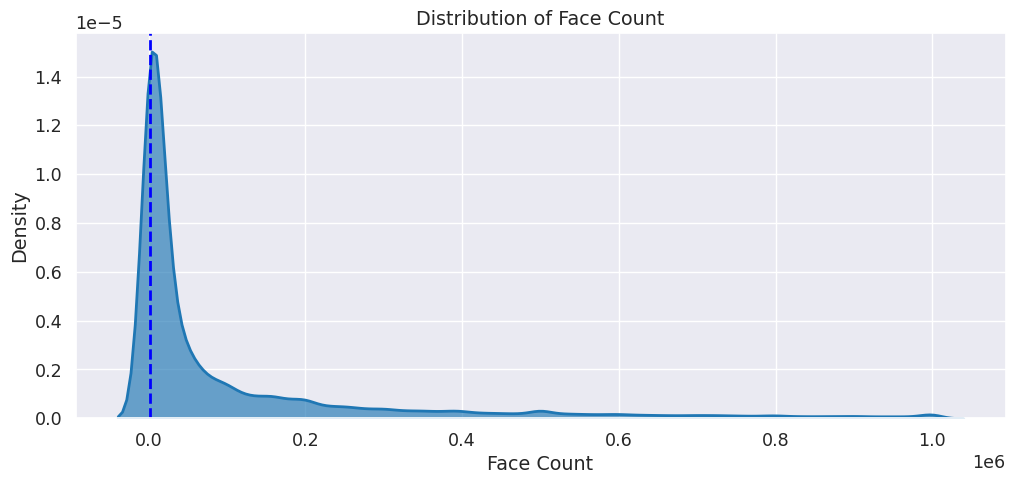

In [41]:
MAX_FACES = 2_000

plt.figure(figsize=(12, 5))
ax=sns.kdeplot(annotations_filtered['faceCount'][annotations_filtered['faceCount']<1e6][::1], fill=True, color='tab:blue', alpha=0.65, linewidth=2)
plt.xlabel("Face Count")
plt.ylabel("Density")
plt.title("Distribution of Face Count")
ax.add_line(Line2D([MAX_FACES]*2, [0, 1], color='b', linestyle='--', linewidth=2))
plt.show()